<img src="images/nri_sm.png" width=30% align="right"/>
# Neural Relational Inference for Interacting Systems
Notebook Author: Jin Yeom (jinyeom@utexas.edu)  
Original Authors: Thomas Kipf, Ethan Fetaya, Kuan-Chieh Wang, Max Welling, Richard Zemal

## Contents
- [Data Generation](#Data-Generation)
    - [Visualization](#Visualization)
- [Graph Neural Network](#Graph-Neural-Network)
- [Neural Relational Inference](#Neural-Relational-Inference)
- [References](#References)

This notebook attempts to understand [this paper](https://arxiv.org/abs/1802.04687) (Kipf et al., 2018) by implementing the Neural Relational Inference (NRI) algorithm with PyTorch. Note that code for generating data is imported from the paper's [original implementation](https://github.com/hudl/relational-inference).

In [1]:
import time
from typing import Tuple, Sequence
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as anime
from IPython.display import HTML
import seaborn as sns
sns.set()
import torch
from torch import nn
from torch.nn import functional as F

## Data Generation

Run the following script below to generate the particle simulation datasets we'll be using.

*NOTE: it seems that there is a bug in ipython that doesn't allow display of `stdout` stream immediately, which means there is no way to know how long this process of data generation takes. Until the bug is fixed, I recommend running this script on terminal! Just to provide a bit of estimation, this process (50000 train; 10000 valid; 10000 test; 5 balls) takes at least **3 hours** to generate on a Macbook Pro.*

In [ ]:
%%bash
mkdir -p datasets/nri/
cd datasets/nri/
# git clone https://github.com/ethanfetaya/NRI.git # for HTTPS
git clone git@github.com:ethanfetaya/NRI.git
python NRI/data/generate_dataset.py \
    --simulation=springs \
    --num-train=50000 \
    --num-valid=10000 \
    --num-test=10000 \
    --length=5000 \
    --length-test=10000 \
    --sample-freq=100 \
    --n-balls=5 \
    --seed=42
rm -rf NRI

### Visualization

In [2]:
def load_dataset(dataset):
    loc_train = np.load(f"datasets/nri/springs/loc_train_{dataset}.npy")
    loc_valid = np.load(f"datasets/nri/springs/loc_valid_{dataset}.npy")
    loc_test = np.load(f"datasets/nri/springs/loc_test_{dataset}.npy")
    return loc_train, loc_valid, loc_test

In [3]:
def visualize_sample(dataset):
    sample_idx = np.random.randint(dataset.shape[0])
    sample = dataset[sample_idx]

    fig = plt.figure()
    ax = plt.axes(xlim=(-3, 3), ylim=(-3, 3))
    scatter, = ax.plot([], [], 'o')

    def init():
        scatter.set_data([], [])
        return scatter,

    def animate(i):
        scatter.set_data(sample[i, 0], sample[i, 1])
        return scatter,

    return anime.FuncAnimation(fig,
                               animate, 
                               init_func=init,
                               frames=sample.shape[0], 
                               interval=25,
                               blit=True)

(50000, 49, 2, 5)


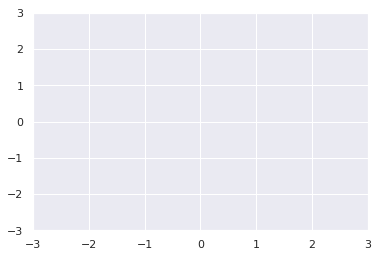

In [5]:
train, valid, test = load_dataset("springs5")
print(train.shape) # (N, T, dims, particles)
    
anim = visualize_sample(train)
HTML(anim.to_html5_video())

## Graph Neural Network

Graph neural networks (GNN) are a speicalized class of neural networks that operate on graph ($G = (V, E)$) data by passing local messages among nodes. There are variations of message passing methods; in our case, the message passing operator is defined as below,

$$
\begin{align*}
v \rightarrow e &: h^l_{(i, j)} = f^l_{e}([h^l_i, h^l_j]) \\
e \rightarrow v &: h^{l + 1}_j = f^l_{v}([\sum_{i \in N_j}h^l_{(i, j)}])
\end{align*}
$$

Each pair of nodes that are connected by an edge sends a message with an output of some function $f_e$ (e.g., a neural network) given concatenated embeddings of the two nodes. Then for each destination node of each edge, its edge signals are aggregated in a sum that is transformed by another function $f_v$. When there are multiple layers of this operator, a message from a node can reach further than just its neighboring nodes.

In [ ]:
def node2edge(h: torch.Tensor, 
              m_in: torch.Tensor, 
              m_out: torch.Tensor) -> torch.Tensor:
    # assuming that the shape of x is (t, f, n),
    h_in = torch.matmul(m_in, h)
    h_out = torch.matmul(m_out, h)
    return torch.cat([h_in, h_out], dim=2)

def edge2node(h: torch.Tensor, m_in: torch.Tensor) -> torch.Tensor:
    # since M_in for edges is the transpose of M_in for nodes,
    return torch.matmul(m_in.t(), h)

In [ ]:
class TwoLayerFcNet(nn.Module):
    r"""
    Two-layered fully connected neural network with dropout and 
    batch normalization, as described in the NRI paper (Kipf, et al.).
    """
    def __init__(self, 
                 in_dim: int, 
                 hid_dim: int, 
                 out_dim: int, 
                 dropout_rate: float = 0.5):
        super(TwoLayerFcNet, self).__init__()
        self.fc0 = nn.Linear(in_dim, hid_dim, bias=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hid_dim, out_dim, bias=False)
        self.bn = nn.BatchNorm1d(out_dim)
    
    def forward(self, x):
        x = F.elu(self.fc0(x))
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        return self.bn(x)

These two components can now be used for building the NRI model.  

*Note that a 1D convolutional neural network can be used instead of a fully-connected network. But we'll get to that later.*

## Neural Relational Inference

![model](images/nri.png)

**Neural Relational Inference** (NRI) model is quite similar to the variational autoencoder in that it consists of an encoder, sampling and a decoder. The encoder takes node embeddings during time $1, ..., T$ and makes an inference on interaction types of each edge (a matrix with shape of $E \times I$, where $E$ is the number of edges and $I$ is the number of interaction types), from which a graph structure is determined by sampling; then the decoder iteratively predicts $\Delta x^t$ given $x^t$, $t = 1, ..., T$.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 in_dim: int, 
                 hid_dim: int, 
                 out_dim: int):
        super(Encoder, self).__init__()
        self.f_emb = TwoLayerFcNet(in_dim, hid_dim, hid_dim)
        self.f_e1 = TwoLayerFcNet(hid_dim * 2, hid_dim, hid_dim)
        self.f_v1 = TwoLayerFcNet(hid_dim, hid_dim, hid_dim)
        self.f_e2 = TwoLayerFcNet(hid_dim * 2, hid_dim, hid_dim)
        
    def forward(self, x, m_in, m_out):
        h = self.f_emb(x)
        h_e = self.f_e1(node2edge(h_v, m_in, m_out))
        h_v = self.f_v1(edge2node(h_e, m_in))
        h_e = self.f_e2(node2edge(h_v, m_in, m_out))
        return F.softmax(h_e)

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

In [ ]:
class NRI(nn.Module):
    def __init__(self):
        super()

## Extending with VQ-VAE

As the NRI model attempts to learn discrete representations of graphs, one can imagine a direct extension of the NRI algorithm with [VQ-VAE](https://arxiv.org/abs/1711.00937v2) (Oord, et al.), a simple generative model that learns discrete representations.

## References

- Neural Relational Inference for Interacting Systems, [arXiv:1802.04687v2 \[stat.ML\]](https://arxiv.org/abs/1802.04687)
- Neural Discrete Representation Learning, [arXiv:1711.00937v2 \[cs.LG\]](https://arxiv.org/abs/1711.00937v2)